In [1]:
# importing dependencies
import numpy as np # matrix math and making toy data
import matplotlib.pyplot as plt # graph
%matplotlib inline
import tensorflow as tf # ML
from tensorflow.contrib.rnn import BasicLSTMCell # LSTM Cell

/usr/local/Cellar/python3/3.6.1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


## PART 1: Making Toy data
First we make a toy data on which we will train our dynamic neural network.

Our data is basically a sentences converted into integers, they are of random lengths. We need to pad the sequences to make them of same length, but this will be later solved while using tf.nn.dynamic_rnn().

It is of 3 parts: [1] data\_, [2]labels\_, [3]seq_lens: an array containing the true lengths of sequences, before padding.

In [2]:
# parameters
maxlen_sent = 512 # maximum length of any sentence
vocab_size = 2048 # size of vocabulary in training set
num_classes = 4 # number of output classes
num_examples = 2000 # number of examples
test_split = 0.2 # ratio of examples in testing data

In [3]:
# making random lenght sentences
data_ = np.asarray([np.random.randint(vocab_size, size = np.random.randint(maxlen_sent)) for _ in range(num_examples)])
# making corresponding one-hot labels for the data
labels_ = np.zeros([num_examples, num_classes])
for i in range(len(labels_)):
    labels_[i][np.random.randint(num_classes)] = 1.
print(data_.shape, type(data_))
print(labels_.shape, type(labels_))

(2000,) <class 'numpy.ndarray'>
(2000, 4) <class 'numpy.ndarray'>


In [4]:
# for using dynamic length modules we also need an array which keeps track of sizes of different sentences
seq_lens = np.array([len(s) for s in data_])

In [6]:
# I am getting a stack throw like this, I guess it is because I have not padded the sequences to
# the proper length
'''
---------------------------------------------------------------------------
ValueError                                Traceback (most recent call last)
<ipython-input-36-c8b16e8fbf05> in <module>()
      7     x_batch, y_batch, seqlen_batch = get_sentence_batch(batch_size, data_train, labels_train, seqlens_train)
      8     feed_dict = {_x:x_batch, _y:y_batch, _seqlens:seqlen_batch}
----> 9     sess.run(train_step, feed_dict = feed_dict)
     10     if e%disp_step == 0:
     11         acc = sess.run(accuracy, feed_dict = feed_dict)

<few more throws>

ValueError: setting an array element with a sequence.
'''

for i in range(len(data_)):
    data_[i] = np.hstack([data_[i], np.zeros(maxlen_sent - len(data_[i]), dtype = np.int32)])
    
# Now I am not getting an error

In [7]:
print('Sample input data:', data_[0])
print('Sample output label:', labels_[0])

Sample input data: [ 376 1555  564 1480  397  331  635 1585 1765 1722 1128  256 1733  374  801
 2030  333  273  842 1150  320  702  371 1588  110 1271 1435 1208 1921  766
 1723  142 1748    7 1639  734 1793 1675 1307 1826  798  530  598  729  411
 1526 2031 1205 1152  321 1340  836  943  107  551  124  527 1569  383 1743
 1244 1051  850 1336 1704  667 1741 1420  393  701  396 1200 1211 1762 1749
 1629  246 1735  488 1881  540 1053 1060 1365 1550  367 1952  247 1025   65
  319  285  951  300 2002 1997 1069  978 1588  549 1728  627    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    

In [8]:
# spliting into trianing and testing dataset
# training
data_train = data_[int(len(data_)*test_split):]
labels_train = labels_[int(len(data_)*test_split):]
seqlens_train = seq_lens[int(len(data_)*test_split):]
# testing
data_test = data_[:int(len(data_)*test_split)]
labels_test = labels_[:int(len(data_)*test_split)]
seqlens_test = seq_lens[:int(len(data_)*test_split)]

In [9]:
# we now make a batch generator function
def get_sentence_batch(batch_size, data_x, data_y, data_seqlens):
    instance_indices = list(range(len(data_x)))
    np.random.shuffle(instance_indices)
    batch = instance_indices[:batch_size]
    x = [data_x[i] for i in batch]
    y = [data_y[i] for i in batch]
    seqlens = [data_seqlens[i] for i in batch]
    return x,y,seqlens

## PART 2: Making the model
Now we make the model. We use tf.nn.dynamic_rnn() as wrapper class for tf.contrib.rnn.BasicLSTMCell(), and pass sequence lengths as one of the arguments thus making sure we use only the useful lengths.

In [10]:
# parameters
batch_size = 32 # batch size
epochs = 200 # number of training epochs
test_epoch = 1 # number of epochs for testing
e_dim = 100 # embedding dimension
hidden_layer_lstm = 128 # size of hidden layer in LSTM cell
disp_step = 10 # after every 10 steps show status

In [11]:
_x = tf.placeholder(tf.int32, [batch_size, maxlen_sent]) # input 
_y = tf.placeholder(tf.float32, [batch_size, num_classes]) # labels
_seqlens = tf.placeholder(tf.int32, [batch_size]) # sequence lengths

In [12]:
# convert to embeddings (supervised not pre-trained)
with tf.name_scope("embeddings"):
    embeddings = tf.Variable(tf.random_uniform([vocab_size, e_dim], -1.0, 1.0), name = 'embeddings')
    embed = tf.nn.embedding_lookup(embeddings, _x)

In [13]:
with tf.variable_scope("lstm"):
    lstm_cell = BasicLSTMCell(hidden_layer_lstm, forget_bias = 1.0)
    outputs, states = tf.nn.dynamic_rnn(lstm_cell, embed, sequence_length = _seqlens, dtype = tf.float32)

# defining weights and biases
W1 = tf.Variable(tf.truncated_normal([hidden_layer_lstm, num_classes]))
b1 = tf.Variable(tf.truncated_normal([num_classes]))

# linear layer
y = tf.matmul(states[1], W1) + b1

# loss
softmax = tf.nn.softmax_cross_entropy_with_logits(logits = y, labels = _y)
cross_entropy = tf.reduce_mean(softmax)

## PART 3: Training the model
We train the model using Adam optimizer, as it performed better during the test.

In [14]:
train_step = tf.train.AdamOptimizer(0.001, 0.9).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(_y,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32)) * 100

In [15]:
# defining sesion and running some ops
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# list of accuracies
acc_list = []

# training
for e in range(epochs):
    x_batch, y_batch, seqlen_batch = get_sentence_batch(batch_size, data_train, labels_train, seqlens_train)
    feed_dict = {_x:x_batch, _y:y_batch, _seqlens:seqlen_batch}
    sess.run(train_step, feed_dict = feed_dict)
    if e%disp_step == 0:
        acc = sess.run(accuracy, feed_dict = feed_dict)
        acc_list.append(acc)
        print('Epoch: {0}, Accuracy: {1}'.format(e, acc))
        
# testing
for e in range(test_epoch):
    x_batch, y_batch, seqlen_batch = get_sentence_batch(batch_size, data_test, labels_test, seqlens_test)
    feed_dict = {_x:x_batch, _y:y_batch, _seqlens:seqlen_batch}
    acc = sess.run(accuracy, feed_dict = feed_dict)
    print('Epoch: {0}, Accuracy: {1}'.format(e, acc))

Epoch: 0, Accuracy: 40.625
Epoch: 10, Accuracy: 43.75
Epoch: 20, Accuracy: 34.375
Epoch: 30, Accuracy: 50.0
Epoch: 40, Accuracy: 40.625
Epoch: 50, Accuracy: 65.625
Epoch: 60, Accuracy: 53.125
Epoch: 70, Accuracy: 56.25
Epoch: 80, Accuracy: 65.625
Epoch: 90, Accuracy: 65.625
Epoch: 100, Accuracy: 75.0
Epoch: 110, Accuracy: 62.5
Epoch: 120, Accuracy: 68.75
Epoch: 130, Accuracy: 56.25
Epoch: 140, Accuracy: 90.625
Epoch: 150, Accuracy: 78.125
Epoch: 160, Accuracy: 75.0
Epoch: 170, Accuracy: 90.625
Epoch: 180, Accuracy: 90.625
Epoch: 190, Accuracy: 87.5
Epoch: 0, Accuracy: 34.375


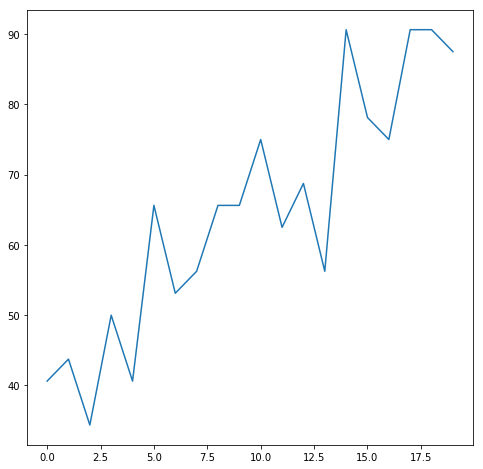

In [16]:
plt.figure(figsize = (8,8))
plt.plot(acc_list)